# Segment Anything Model 

Video: https://www.youtube.com/watch?v=MElR1HM4Y6Y (Image Segmentation)

The Segment Anything Model (SAM) is a model developed by Meta. This model is able to generate automatic masks for objects within an image. It is fairy easy and straightforward to setup and use. In this notebook we will learn how to use SAM to generate over an entire image, how to set up a boundary box for masks, and how to use specific points to create masks.

References:

https://github.com/facebookresearch/segment-anything

## Setup

### Imports

In [2]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import cv2 
import torchvision

### Displaying Masks

This block of code will allow us to display our generated masks over our original image. This is a little better than displaying the masks on their own as it provides a reference to see exactly what it segmented.

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Load the Image

Let's load our image. The image we will be using is of dendrite growth in a material. This type of image is good for segmentation tasks as the different regions are pretty well separated. The SAM model goes down in accuracy the more blurred and small the objects become. 

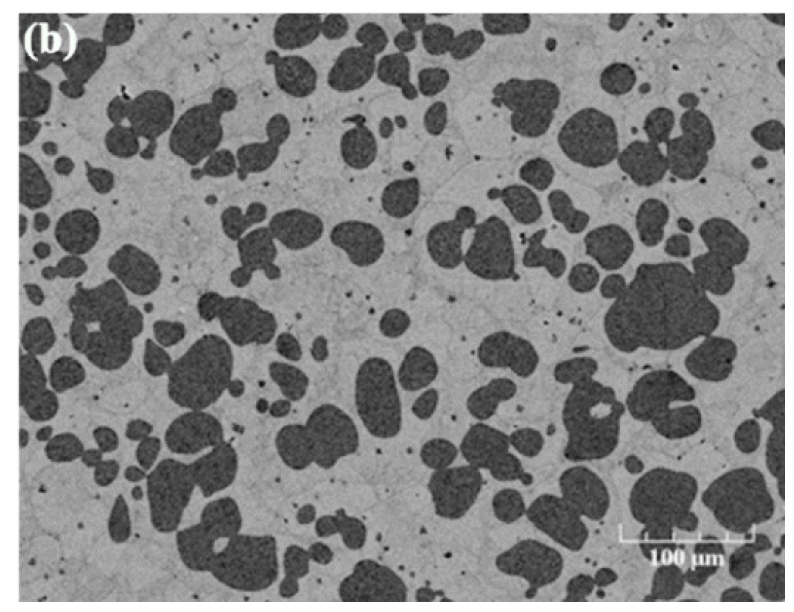

In [4]:
def load_image(image_file):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

image_file = 'dendrite1.png'
image = load_image(image_file)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

### Load our Model

To run the SAM model we need to provide the specific model file. This is downloaded from the SAM github page. The model we are using today is already downloaded and set up to use. However, if you want to experiment with the different models then the link to do so is provided. 

The model we will be using is the SAM-Huge model which contains 632 million parameters and 48 layers. The other models are the SAM-Large and SAM-Base. The SAM-Large has 307 million parameters and 24 layers. The SAM-Base has 86 million parameters and 12 layers. 

Using smaller models can be better for tasks that don't neccessarily need the improved accuracy as the lighter models require less computational cost.

Download the different models: https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#model-checkpoints

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

/opt/miniconda3/envs/mainENV/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


KeyboardInterrupt: 

### Setting up the Mask Generator

When setting up the mask generator there are some important parameters that can be defined in order to tune the model a bit. If a parameter is not defined the default setting will be used. 

##### __points_per_side__ 

This parameter defines how many points are sampled along the boundary of the image/boundary box. Increasing this value generates more points within the mask which can improve the accuracy of the segmentation. The more points per side sampled, the higher the computational cost. 

__Default: 32__

##### __points_per_batch__

This sets the number of points to be run simultaneously. Increasing this value can speed up the processing but will use more memory.

__Default: 64__

##### __pred_iou_thres__ 

This parameter sets a threshold for which masks are kept. This helps to filter out low quality masks. Increasing this parameter produces higher-quality masks but generates fewer masks overall. Decreasing this parameter will generate more masks and keep lower quality ones.

__Default: 0.88__

##### __stability_score_thresh__

This parameter sets a threshold for the stability score. The stability is how consistently the mask is generated. For example, if a mask can be generated consistently over multiple runs of the model (under slightly different conditions) than it is considered to have a higher stability than a mask that is generated only sometimes. Increasing this parameter keeps the very stable masks and discards the less stable ones. This parameter is useful for tasks for which the model needs to be precise and accurate. 

__Default: 0.95__

##### __crop_nms_thresh__

This parameter is used to remove duplicate or overlapping masks. A lower nms_thresh value will result in more overlapping masks being removed. For tasks where you have very distinct objects a low threshold is good. For tasks where you need to capture variation in overlapping regions use a higher threshold value.

__Default: 0.7__

##### __crop_n_layers__

This parameter controls how many sub-images are used for mask generation. Increasing this value can help in getting more detailed masks at a higher computational cost. Furthermore, it helps the model segment out smaller objects more accurately. 

__Default: 0__ (no additional layers are used)

##### __crop_n_points_downscale_factor__ 

This parameter downscales the number of points to use in each cropped layer. Downscaling reduces the number of points in each crop (sub-image) which can speed up processing but decrease the accuracy of the masks. This parameter is useful to balance detail and speed. Increasing this value will increase speed and decrease detail. 

__Default: 1__ (no downscaling)

##### __min_mask_region_area__ 

This sets the minimum number of pixels required in a mask for it to be considered valid. Masks that have areas less than this value will be discarded. This is useful for tasks for which small details are unimportant. Increasing this value will cause the model to focus on larger regions.

__Default: 0__ (no minimum area)

In [6]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,             # Model to use for mask generation
    points_per_side=32,   
    points_per_batch=64,               # Default: 32
    pred_iou_thresh=0.88,              # Default: 0.88
    stability_score_thresh=0.95,       # Default: 0.95
    crop_nms_thresh=0.7,                    # Default: 0.7
    crop_n_layers=0,                   # Default: 0
    crop_n_points_downscale_factor=1,  # Default: 1
    min_mask_region_area=0             # Default: 0
)

## Automatic Mask Generation

One of the uses of SAM that makes it so powerful is the ability to segment out objects from an image without any direction from a human. 

To run automatic mask generation only a single line of code is needed. 

In [7]:
masks = mask_generator.generate(image)

We can see how many masks we generated by checking the length of the masks list. 

In [8]:
len(masks)

225

After generating these masks we can plot them on top of the original image to see what the model found. 

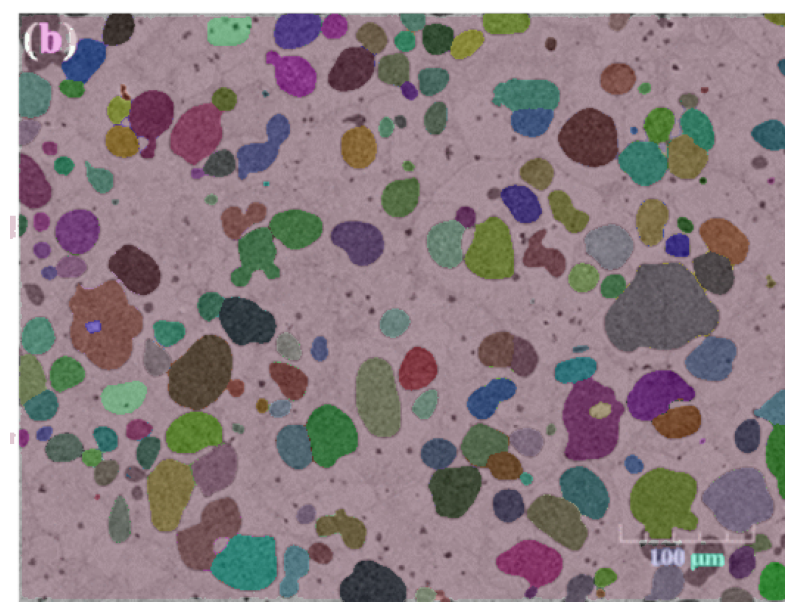

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

Pretty good! The model did a good job at finding the individual large grain blobs in the microstructure while segmenting out the second phase as a single mask. As shown above, the model missed capturing some of the very small grains. The scale for the image as well as any marker on the image may create unwanted masks as seen above. For best results use a clean image without any markings on it. 

Within each mask there is a list of values that the model created. 

In [10]:
print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


##### __segmentation__

2D area with the same dimensions as the image. This contains True values for pixels in the mask and False for pixels not in the mask. This is useful for further image processing tasks.

##### __area__

This is the total pixels contained within the mask. This value is useful for filtering masks based on their size or for calculating the percent of the image they fill up. 

##### __bbox__

 This key represents the bounding box around the mask (the smallest rectangle that can contain the mask). These can be extracted to find regions of interest for further processing. 

##### __predicted_iou__

This is the estimated quality for the predicted mask. Higher values means a higher confidence for each mask. 

##### __point_coords__ 

This is the points used to generate the mask. They are useful for seeing what points prompted the model to generate a mask. By using these points the output of the model can be closely replicated or modified. 

##### __stability_score__

This is the measure of how stable the mask is. This can be used to filter out unstable and inconsistent masks. 

##### __crop_box__

This contains the coordinates of the crop box that was used when generating the mask. The crop box is the region of the image that was focused on for generating that mask. This value allows you to map the mask back to the original image coordinates.

As an example of how we might process the generated masks let's remove the background mask. First we will get the list of all the mask areas and then we will remove the one with the greatest area.


In order to view the useful masks, we need to get rid of the largest "background" mask. This is helpful not only for visualization, but for further calculations such as finding the volume fraction of secondary phase.

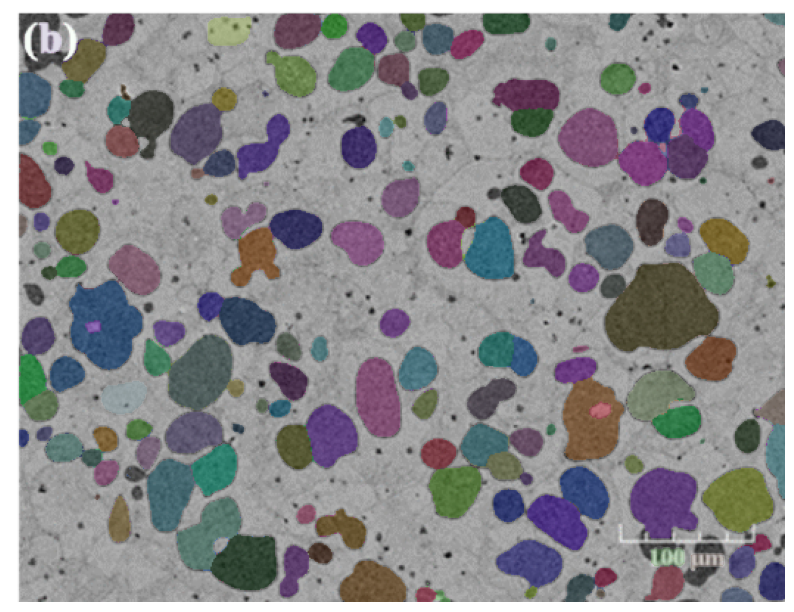

In [11]:
# sort the masks by area 
sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

# remove the mask with the largest area (for this case specifically as finding the volume fraction requires us to drop the background mask)
sorted_masks = sorted_masks[1:]

# display the image with the remaining masks
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(sorted_masks)
plt.axis('off')
plt.show()

Now that we have removed the background mask, we can use the area of the rest of the masks to find the volume fraction. This is done by summing up the area of each individual mask and dividing it by the size of the image. Because the SAM model is prone to small errors in masking, this number should be treated as an approximate volume fraction. As you can see in the image above, the very small objects are not caught in the masking. This can be partially fixed by adjusting the parameters of the mask generator but it is hard to get every single one without picking up extra noise. 

In [29]:
# Find the volume fraction occupied by the second phase 
total_area = image.shape[0] * image.shape[1]
phase_area = sum([mask['area'] for mask in sorted_masks])
volume_fraction = phase_area / total_area
print(f"Volume fraction: {volume_fraction*100:.2f}%")

Volume fraction: 66.82%


## Point-based Mask Generation 

The next way you can generate masks on an image is to use manually chosen points to prompt the model. This is very useful when you only care about certain objects being segmented but you don't neccesarily want everything to be segmented. When using mulitple inputs to the predictor model a torch tensor must be used.

First we need to set up a new mask generator. This is because we aren't using the automatic mask function but instead we are switching to a prediction based model. The prediction model takes in user-provided inputs to generate the masks. 

In [12]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
# Set the image for SAM predictor
predictor.set_image(image)

Next we will choose the points to use as inputs. This code displays the image and allows the user to click points they want to use as an input. To exist this window press 'q'. The window will not close, but simple minimize it or click off to continue running the cell. The examples later in this notebook will use the same window for user input segmentation. 

Click on the blobs to select points. Press 'q' to quit and save points.
Selected points: [(442, 200), (132, 243), (126, 294)]


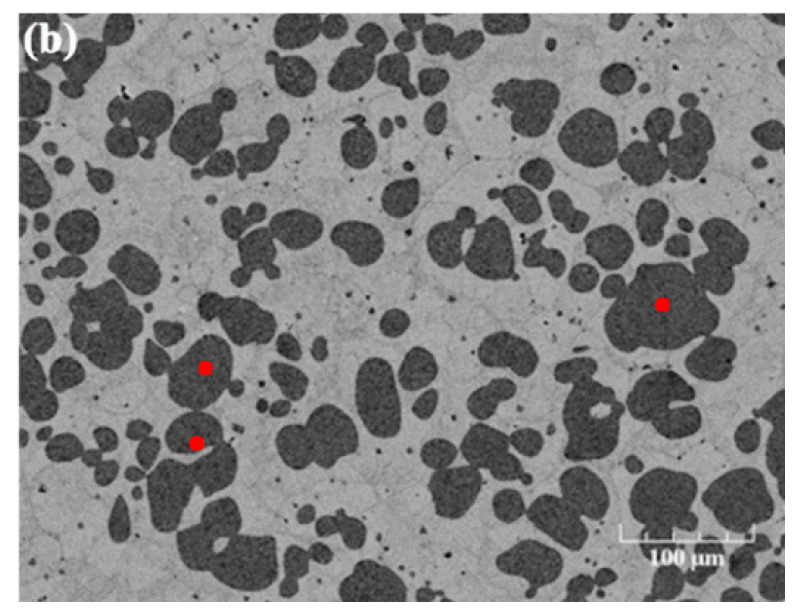

In [42]:
from segment_anything.utils.transforms import ResizeLongestSide

# Load the image
image = load_image(image_file)

# Initialize a list to store the points
points = []

# Mouse callback function to capture points
def select_point(event, x, y, flags, param):
    global points
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv2.circle(image, (x, y), 5, (255, 0, 0), -1)
        cv2.imshow('Select Points', image)



# Create a window and bind the function to window
cv2.namedWindow('Select Points')
cv2.setMouseCallback('Select Points', select_point)

# Display the image and wait for points selection
print("Click on the blobs to select points. Press 'q' to quit and save points.")
while True:
    cv2.imshow('Select Points', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Press 'q' to quit
        break

# Close the window
cv2.destroyAllWindows()

# Print selected points
print(f"Selected points: {points}")

# Display the image with the selected points
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.scatter([p[0] for p in points], [p[1] for p in points], color='red')
plt.axis('off')
plt.show()

After we have selected the points we need to do some preprocessing on them to make sure they are suitable to pass into the SAM model. The model expects us to pass in tensors rather than numpy arrays and so we must convert them. The SAM model expects each point to have a 1 or a 0 attatched to it. This is how it tells what points it needs to focus on and what points to avoid. This is helpful to use if the model is frequently getting something wrong or if you need to select an object without including an inner segment. For now we are attaching 1 to each of our points to select it. Next, we need to resize it to the same image that the image is. This makes sure that it can be mapped onto the image we are working with. Lastly, we split each point into it's own batch. This is how you can use the points to select different objects. If they were all part of the same batch then the model would try to find a single object using all the points which can confuse it and create worse outputs. If you want to have one object that uses multiple points to tell it where and where not to look then you would put those into the same batch. 

In [43]:
# Convert points to numpy array and prepare for batch processing
input_points = np.array(points)  # Shape: (4, 2) if there are 4 points
input_labels = np.ones(len(points))  # Labels are all 1 for foreground

# Prepare points for SAM input (similar to how boxes are prepared)
input_points_tensor = torch.tensor(input_points, dtype=torch.float32, device=predictor.device)  # Shape: (4, 2)

# Transform the points to match the resized image dimensions
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)
transformed_points = resize_transform.apply_coords_torch(input_points_tensor, image.shape[:2])

# Prepare batched points tensor (each point as a separate batch)
points_tensor_batched = transformed_points.unsqueeze(1)  # Shape: (4, 1, 2)
labels_tensor_batched = torch.ones((transformed_points.shape[0], 1), dtype=torch.int, device=predictor.device)  # Shape: (4, 1)


In [44]:
print(points_tensor_batched.shape)
print(labels_tensor_batched.shape)

torch.Size([3, 1, 2])
torch.Size([3, 1])


We will now pass the chosen points as prompts into the SAM model and generate the corresponding masks. 

In [45]:
# Predict masks using transformed points in batch mode
masks, _, _ = predictor.predict_torch(
    point_coords=points_tensor_batched,  # Shape: (4, 1, 2)
    point_labels=labels_tensor_batched,  # Shape: (4, 1)
    boxes=None,
    multimask_output=False,  # Set to False to get one mask per point
)

print(f"Generated {len(masks)} masks.")

Generated 3 masks.


Lastly, we will display the masks onto the original image (to see what it found and how accurately it found it) as well as show the points that we initially chose. 

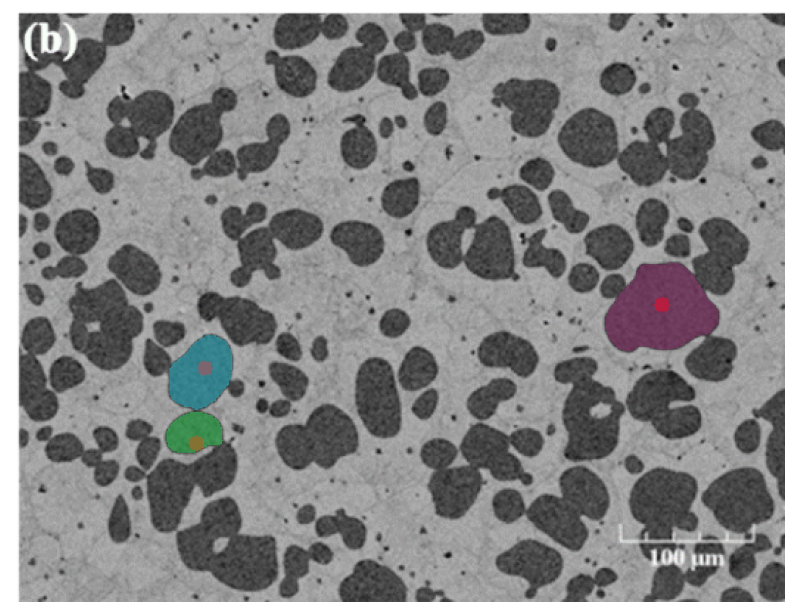

In [46]:
# Display the results
plt.figure(figsize=(10, 10))
plt.imshow(image)

# Iterate over each point's output
for i in range(masks.shape[0]):  # Access each mask in the batch
    show_mask(masks[i, 0].cpu().numpy(), plt.gca(), random_color=True)  # Show each mask on the image

plt.axis('off')
plt.show()

We can also find the volume fraction of the masks generated similar to what was done above. However, these masks do not have an 'area' property attatched to them and so you have to more manually sum the pixels in the mask. 

In [48]:
# Initialize a list to store the volume fractions for each mask
volume_fractions = []

# Iterate over each mask in the batch
for i in range(masks.shape[0]):
    # Convert the mask tensor to a numpy array
    mask_np = masks[i, 0].cpu().numpy()  # Shape: (height, width)
    
    # Calculate the mask area by summing the pixels in the mask
    mask_area = np.sum(mask_np)
    
    # Calculate the total area of the image (height * width)
    total_area = image.shape[0] * image.shape[1]
    
    # Calculate the volume fraction of the mask
    volume_fraction = mask_area / total_area
    
    # Append the calculated volume fraction to the list
    volume_fractions.append(volume_fraction)

# Print the volume fraction
print(f"Volume fraction of second phase: {sum(volume_fractions)}")

Volume fraction of second phase: 0.027500331044397783


## Boundry Box Image Segmentation

In addition to specifying points to use as prompts for the SAM model you can also create boundary boxes to guide the model to areas of interest. 

In [49]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

image = load_image(image_file)
predictor = SamPredictor(sam)
# Set the image for SAM predictor
predictor.set_image(image)

/opt/miniconda3/envs/sam/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


This section of code lets you draw boxes on the image to prompt the model with. There is a slight delay to creating the box. Similar to before, when you are done you can press 'q'. 

In [50]:
image = load_image(image_file)
# Convert the image from BGR to RGB for display and further processing
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize a list to store the bounding boxes
bounding_boxes = []
drawing = False  # True if mouse is pressed
ix, iy = -1, -1  # Initial position for drawing

# Mouse callback function to draw rectangles
def draw_rectangle(event, x, y, flags, param):
    global ix, iy, drawing, bounding_boxes, image_rgb

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            img_copy = image_rgb.copy()
            cv2.rectangle(img_copy, (ix, iy), (x, y), (0, 255, 0), 2)
            cv2.imshow('Draw Bounding Boxes', cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR))

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        # Ensure (x1, y1) is the top-left and (x2, y2) is the bottom-right
        x1, y1, x2, y2 = min(ix, x), min(iy, y), max(ix, x), max(iy, y)
        bounding_boxes.append((x1, y1, x2, y2))
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.imshow('Draw Bounding Boxes', cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))

# Create a window and bind the function to the window
cv2.namedWindow('Draw Bounding Boxes')
cv2.setMouseCallback('Draw Bounding Boxes', draw_rectangle)

# Display the image and wait for bounding boxes to be drawn
print("Draw bounding boxes on the blobs by clicking and dragging. Press 'q' to quit and save boxes.")
while True:
    cv2.imshow('Draw Bounding Boxes', cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Press 'q' to quit
        break

# Close the window
cv2.destroyAllWindows()

# Print selected bounding boxes
print(f"Selected bounding boxes: {bounding_boxes}")

Draw bounding boxes on the blobs by clicking and dragging. Press 'q' to quit and save boxes.
Selected bounding boxes: [(152, 80, 399, 236), (76, 273, 182, 393)]


Similar to the points, we now need to turn our numpy array of boundary boxes into a useable tensor for the SAM model. However, these boxes do not need 1s or 0s attached to them. The model will use these boxes instead as areas to focus on rather than exact point prompts. Think of it like creating a mini image for it to segment on. 

In [51]:
# Convert bounding boxes to NumPy array in the required format (x1, y1, x2, y2)
input_boxes = np.array(bounding_boxes)  # Shape: (N, 4)

# Convert to a PyTorch tensor and move to the correct device
input_boxes_tensor = torch.tensor(input_boxes, device=predictor.device) # Shape: (N, 4)

input_boxes2 = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=predictor.device)

print(input_boxes_tensor.shape)
print(input_boxes2.shape)

print(input_boxes_tensor)
print(input_boxes2)

torch.Size([2, 4])
torch.Size([4, 4])
tensor([[152,  80, 399, 236],
        [ 76, 273, 182, 393]])
tensor([[  75,  275, 1725,  850],
        [ 425,  600,  700,  875],
        [1375,  550, 1650,  800],
        [1240,  675, 1400,  750]])


We will pass the selected boxes into our model as prompts.

In [52]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes_tensor, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

Lastly, like before, we will display the boxes on the image as well as the masks that the model generated. 

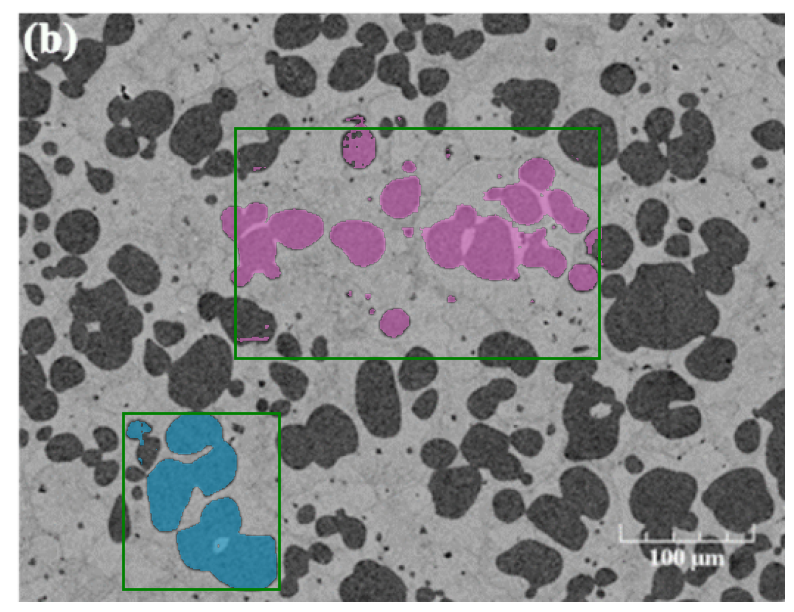

Generated 2 masks.


In [53]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes_tensor:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

print(f"Generated {len(masks)} masks.")


We can sum up the pixels of each mask to find the volume fraction they occupy. 

In [54]:
# Initialize a list to store the volume fractions for each mask
volume_fractions = []

# Iterate over each mask in the batch
for i in range(masks.shape[0]):
    # Convert the mask tensor to a numpy array
    mask_np = masks[i, 0].cpu().numpy()  # Shape: (height, width)
    
    # Calculate the mask area by summing the pixels in the mask
    mask_area = np.sum(mask_np)
    
    # Calculate the total area of the image (height * width)
    total_area = image.shape[0] * image.shape[1]
    
    # Calculate the volume fraction of the mask
    volume_fraction = mask_area / total_area
    
    # Append the calculated volume fraction to the list
    volume_fractions.append(volume_fraction)

# Print the volume fraction
print(f"Volume fraction of second phase: {sum(volume_fractions)}")

Volume fraction of second phase: 0.07489643039555076


# Try it Yourself!
- Load the dendrite2 image
- Use automatic mask generator to try to segment out the images 
- Segment out the objects using boundary boxes. Experiment with how large you can get the boxes with accurate results 
- Find the volume fractions of the dendrites

In [82]:
# code here

`